/tmp/ipykernel_25232/368443134.py:90: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['professor_rating'].fillna(df['professor_rating'].mean(), inplace=True)
/tmp/ipykernel_25232/368443134.py:91: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

Balanced and enriched dataset generated as 'course_difficulty_dataset.csv'!


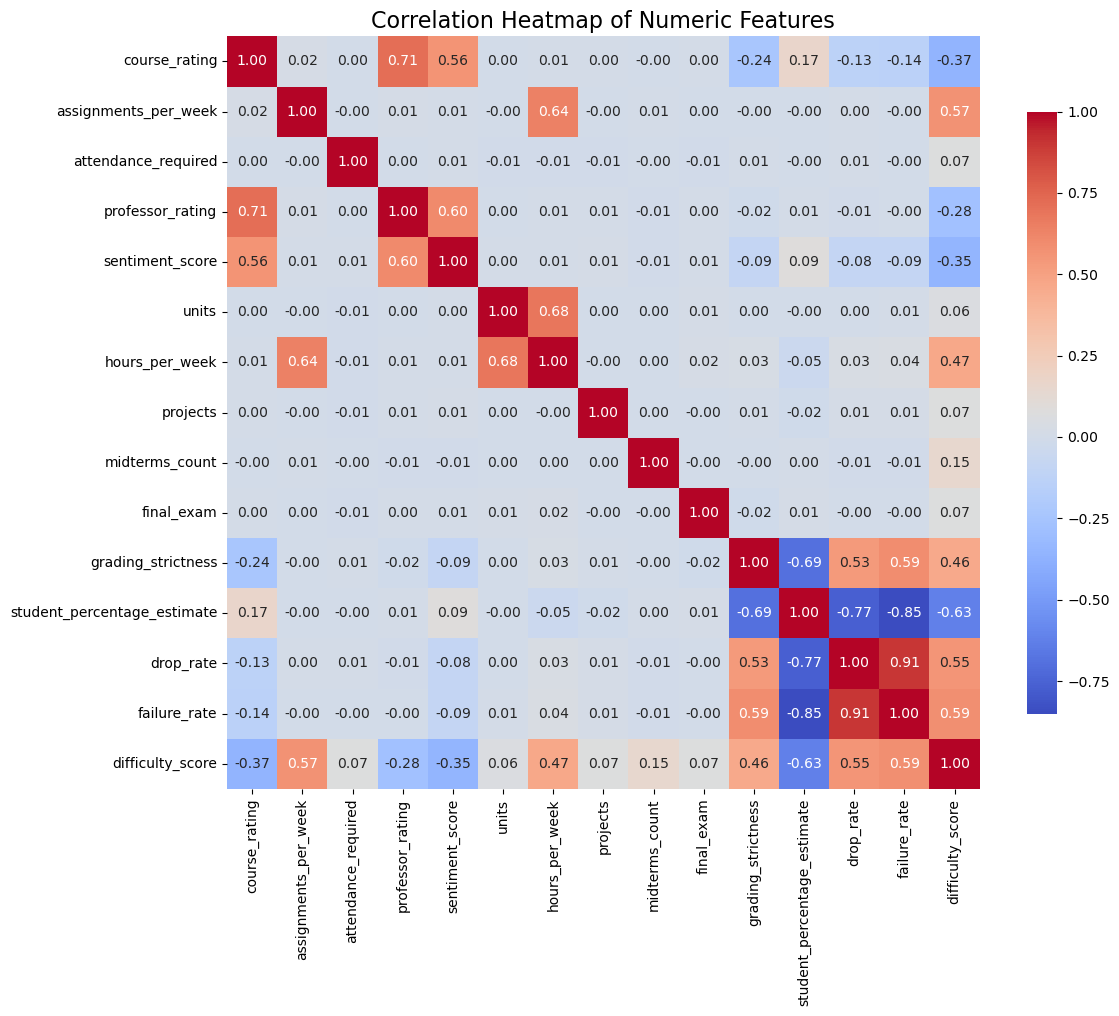

In [2]:
import pandas as pd
import numpy as np
import random

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Number of data points
num_samples = 20000

# Generate independent features first
professor_rating = np.round(np.random.uniform(1.0, 5.0, num_samples), 1)
grading_strictness = np.round(np.random.uniform(1.0, 5.0, num_samples), 1)
assignments_per_week = np.random.randint(0, 6, num_samples)
attendance_required = np.random.choice([0, 1], num_samples)
# course_level = np.random.choice(['Undergrad', 'Grad', 'Elective', 'Core'], num_samples)
projects = np.random.choice([0, 1], num_samples)
midterms_count = np.random.randint(0, 3, num_samples)
final_exam = np.random.choice([0, 1], num_samples)
subject_area = np.random.choice(['STEM', 'Humanities', 'Social Science'], num_samples)

# New features
unit_choices = [3, 3, 3, 6, 9, 9, 9, 9, 9, 12, 12]
units = np.random.choice(unit_choices, num_samples)

# Stronger link between units and hours (with variation to simulate 'easy' courses)

subject_penalty = [5 if s == 'STEM' else -3 if s == 'Humanities' else 0 for s in subject_area]
student_percentage_estimate = (
    90 - 5 * grading_strictness - np.array(subject_penalty) + np.random.normal(0, 5, num_samples)
)

student_percentage_estimate = np.clip(student_percentage_estimate, 50, 100)
student_percentage_estimate = np.round(student_percentage_estimate, 1)

# Failure rate derived from inverse of student performance with noise
failure_rate = np.clip((100 - student_percentage_estimate) / 100 + np.random.normal(0, 0.05, num_samples), 0, 0.4)
failure_rate = np.round(failure_rate, 2)

# Drop rate now related to failure rate with some noise
drop_rate = np.clip(failure_rate * 0.7 + np.random.normal(0, 0.03, num_samples), 0, 0.3)
drop_rate = np.round(drop_rate, 2)

hours_per_week = (
    0.5 * assignments_per_week * np.random.uniform(2.0, 3.0, num_samples) +
    0.7 * units +
    0.2 * (100 - student_percentage_estimate) * 0.1 +
    np.random.normal(0, 1.0, num_samples)
)
hours_per_week = np.clip(hours_per_week, 1, 20).astype(int)

# Course rating influenced by prof rating & grading strictness
course_rating = 0.6 * professor_rating - 0.2 * grading_strictness + np.random.normal(0, 0.5, num_samples)
course_rating = np.clip(course_rating, 1.0, 5.0)
course_rating = np.round(course_rating, 1)

# Sentiment score depends on course rating, prof rating, and drop rate
sentiment_score = (
    0.25 * (course_rating - 3) +
    0.25 * (professor_rating - 3) -
    0.5 * drop_rate +
    np.random.normal(0, 0.5, num_samples)
)
sentiment_score = np.clip(sentiment_score, -1.0, 1.0)
sentiment_score = np.round(sentiment_score, 2)


# Combine into DataFrame
df = pd.DataFrame({
    'course_rating': course_rating,
    'assignments_per_week': assignments_per_week,
    'attendance_required': attendance_required,
    'professor_rating': np.round(professor_rating, 1),
    'sentiment_score': sentiment_score,
    # 'course_level': course_level,
    'subject_area': subject_area,
    'units': units,
    'hours_per_week': hours_per_week,
    'projects': projects,
    'midterms_count': midterms_count,
    'final_exam': final_exam,
    'grading_strictness': grading_strictness,
    'student_percentage_estimate': student_percentage_estimate,
    'drop_rate': drop_rate,
    'failure_rate': failure_rate
})

# Fill missing values for rating/sentiment simulation (temporarily)
df['professor_rating'].fillna(df['professor_rating'].mean(), inplace=True)
df['sentiment_score'].fillna(df['sentiment_score'].mean(), inplace=True)

# Difficulty scoring function with subject/failure/drop rate influence
def assign_difficulty(row):
    score = 0
    feedback_weight = (row['student_percentage_estimate'] - 50) / 50  # 0 to 1
    feedback_weight = np.clip(feedback_weight, 0, 1)

    # Apply subject-based weight multiplier (more weight in STEM)
    weight_multiplier = 1.3 if row['subject_area'] == 'STEM' else 1.0

    score += weight_multiplier * (row['assignments_per_week'] * 1.5)
    score += weight_multiplier * (row['attendance_required'] * 1.0)
    score -= weight_multiplier * (row['course_rating'] * 2 * feedback_weight)
    score -= weight_multiplier * (row['professor_rating'] * 1.2 * feedback_weight)
    score -= weight_multiplier * (row['sentiment_score'] * 5 * feedback_weight)
    score += weight_multiplier * (row['grading_strictness'] * 1.0)
    score += weight_multiplier * (row['hours_per_week'] * 0.3)
    score += weight_multiplier * (row['midterms_count'] * 1.2)
    score += weight_multiplier * (row['final_exam'] * 1.0)
    score += weight_multiplier * (row['projects'] * 0.8)
    score += weight_multiplier * ((100 - row['student_percentage_estimate']) * 0.05)
    score += weight_multiplier * ((row['units'] - row['hours_per_week']) * -0.3)
    score += weight_multiplier * (row['drop_rate'] * 10)
    score += weight_multiplier * (row['failure_rate'] * 8)
    score += np.random.normal(0, 1)

    return score

# Assign raw difficulty score for balancing
df['difficulty_score'] = df.apply(assign_difficulty, axis=1)

# Sort by score and assign labels to balance distribution (approx. 40-30-30)
df = df.sort_values(by='difficulty_score').reset_index(drop=True)
df.loc[:num_samples*0.3, 'difficulty_level'] = 'Easy'
df.loc[num_samples*0.3:num_samples*0.65, 'difficulty_level'] = 'Medium'
df.loc[num_samples*0.65:, 'difficulty_level'] = 'Hard'

# Final shuffle
df = df.sample(frac=1).reset_index(drop=True)

# Define 10 diverse anomaly rows
anomalies = pd.DataFrame([
    # 1. Zero assignments, high hours
    {'course_rating': 3.0, 'assignments_per_week': 0, 'attendance_required': 1,
     'professor_rating': 4.0, 'sentiment_score': 0.2, 'subject_area': 'STEM',
     'units': 6, 'hours_per_week': 20, 'projects': 1, 'midterms_count': 1, 'final_exam': 1,
     'grading_strictness': 3.0, 'student_percentage_estimate': 80, 'drop_rate': 0.05, 'failure_rate': 0.1},

    # 2. High GPA, high failure
    {'course_rating': 4.5, 'assignments_per_week': 3, 'attendance_required': 1,
     'professor_rating': 4.5, 'sentiment_score': 0.8, 'subject_area': 'STEM',
     'units': 9, 'hours_per_week': 12, 'projects': 1, 'midterms_count': 2, 'final_exam': 1,
     'grading_strictness': 4.0, 'student_percentage_estimate': 95, 'drop_rate': 0.05, 'failure_rate': 0.4},

    # 3. Humanities with extreme grading
    {'course_rating': 2.0, 'assignments_per_week': 1, 'attendance_required': 0,
     'professor_rating': 3.0, 'sentiment_score': -0.3, 'subject_area': 'Humanities',
     'units': 3, 'hours_per_week': 5, 'projects': 0, 'midterms_count': 0, 'final_exam': 1,
     'grading_strictness': 5.0, 'student_percentage_estimate': 60, 'drop_rate': 0.1, 'failure_rate': 0.3},

    # 4. Low units, massive time
    {'course_rating': 3.0, 'assignments_per_week': 2, 'attendance_required': 1,
     'professor_rating': 3.5, 'sentiment_score': 0.0, 'subject_area': 'Social Science',
     'units': 3, 'hours_per_week': 20, 'projects': 1, 'midterms_count': 1, 'final_exam': 1,
     'grading_strictness': 3.0, 'student_percentage_estimate': 75, 'drop_rate': 0.1, 'failure_rate': 0.2},

    # 5. High sentiment, high dropout
    {'course_rating': 4.0, 'assignments_per_week': 2, 'attendance_required': 1,
     'professor_rating': 4.0, 'sentiment_score': 1.0, 'subject_area': 'STEM',
     'units': 9, 'hours_per_week': 10, 'projects': 1, 'midterms_count': 1, 'final_exam': 1,
     'grading_strictness': 2.5, 'student_percentage_estimate': 85, 'drop_rate': 0.3, 'failure_rate': 0.1},

    # 6. High prof rating, low course rating
    {'course_rating': 1.0, 'assignments_per_week': 1, 'attendance_required': 1,
     'professor_rating': 5.0, 'sentiment_score': -0.5, 'subject_area': 'STEM',
     'units': 6, 'hours_per_week': 8, 'projects': 0, 'midterms_count': 1, 'final_exam': 1,
     'grading_strictness': 4.0, 'student_percentage_estimate': 70, 'drop_rate': 0.2, 'failure_rate': 0.2},

    # 7. Final exam + midterms + no hours
    {'course_rating': 3.5, 'assignments_per_week': 2, 'attendance_required': 1,
     'professor_rating': 3.5, 'sentiment_score': 0.0, 'subject_area': 'Social Science',
     'units': 6, 'hours_per_week': 0, 'projects': 1, 'midterms_count': 2, 'final_exam': 1,
     'grading_strictness': 3.0, 'student_percentage_estimate': 65, 'drop_rate': 0.1, 'failure_rate': 0.25},

    # 8. Low feedback, labeled easy (add after label assignment manually if needed)
    {'course_rating': 2.0, 'assignments_per_week': 1, 'attendance_required': 0,
     'professor_rating': 2.0, 'sentiment_score': -0.7, 'subject_area': 'Humanities',
     'units': 3, 'hours_per_week': 4, 'projects': 0, 'midterms_count': 0, 'final_exam': 0,
     'grading_strictness': 1.0, 'student_percentage_estimate': 52, 'drop_rate': 0.05, 'failure_rate': 0.1},

    # 9. Conflicting feedback
    {'course_rating': 5.0, 'assignments_per_week': 3, 'attendance_required': 1,
     'professor_rating': 5.0, 'sentiment_score': -1.0, 'subject_area': 'STEM',
     'units': 12, 'hours_per_week': 15, 'projects': 1, 'midterms_count': 2, 'final_exam': 1,
     'grading_strictness': 3.5, 'student_percentage_estimate': 90, 'drop_rate': 0.05, 'failure_rate': 0.05},

    # 10. Everything zero (extreme edge case)
    {'course_rating': 1.0, 'assignments_per_week': 0, 'attendance_required': 0,
     'professor_rating': 1.0, 'sentiment_score': -1.0, 'subject_area': 'Humanities',
     'units': 3, 'hours_per_week': 0, 'projects': 0, 'midterms_count': 0, 'final_exam': 0,
     'grading_strictness': 1.0, 'student_percentage_estimate': 50, 'drop_rate': 0.0, 'failure_rate': 0.0},
])

# # Optional: Mark anomalies
# anomalies['is_anomaly'] = 1
# df['is_anomaly'] = 0

# Assign raw difficulty score for balancing
anomalies['difficulty_score'] = anomalies.apply(assign_difficulty, axis=1)

num_anomalies = len(anomalies)

# Sort by score and assign labels to balance distribution (approx. 40-30-30)
anomalies = anomalies.sort_values(by='difficulty_score').reset_index(drop=True)
anomalies.loc[:num_anomalies*0.3, 'difficulty_level'] = 'Easy'
anomalies.loc[num_anomalies*0.3:num_anomalies*0.65, 'difficulty_level'] = 'Medium'
anomalies.loc[num_anomalies*0.65:, 'difficulty_level'] = 'Hard'

# Append to df
df = pd.concat([df, anomalies], ignore_index=True)

df.to_csv('course_difficulty_dataset.csv', index=False)

print("Balanced and enriched dataset generated as 'course_difficulty_dataset.csv'!")
df.head()


import seaborn as sns
import matplotlib.pyplot as plt
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()

In [3]:
df

,course_rating,assignments_per_week,attendance_required,professor_rating,sentiment_score,subject_area,units,hours_per_week,projects,midterms_count,final_exam,grading_strictness,student_percentage_estimate,drop_rate,failure_rate,difficulty_score,difficulty_level
0,1.0,3,0,1.8,-0.48,Social Science,12,13,1,2,0,4.1,66.1,0.25,0.32,21.247752,Hard
1,1.0,1,1,2.0,-0.70,Social Science,9,8,1,0,1,1.5,93.5,0.08,0.09,8.399222,Easy
2,1.6,3,1,3.6,-1.00,Humanities,9,12,1,0,0,3.6,70.7,0.22,0.34,18.504086,Medium
3,1.0,2,0,2.6,-1.00,STEM,9,8,0,1,1,2.9,68.9,0.26,0.31,21.957630,Hard
4,1.5,1,0,1.4,-0.07,STEM,9,6,1,0,0,2.5,79.4,0.03,0.03,4.552512,Easy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20005,2.0,1,0,3.0,-0.30,Humanities,3,5,0,0,1,5.0,60.0,0.10,0.30,13.162826,Medium
20006,5.0,3,1,5.0,-1.00,STEM,12,15,1,2,1,3.5,90.0,0.05,0.05,14.160536,Medium
20007,3.0,0,1,4.0,0.20,STEM,6,20,1,1,1,3.0,80.0,0.05,0.10,16.843242,Hard
20008,1.0,1,1,5.0,-0.50,STEM,6,8,0,1,1,4.0,70.0,0.20,0.20,19.446587,Hard


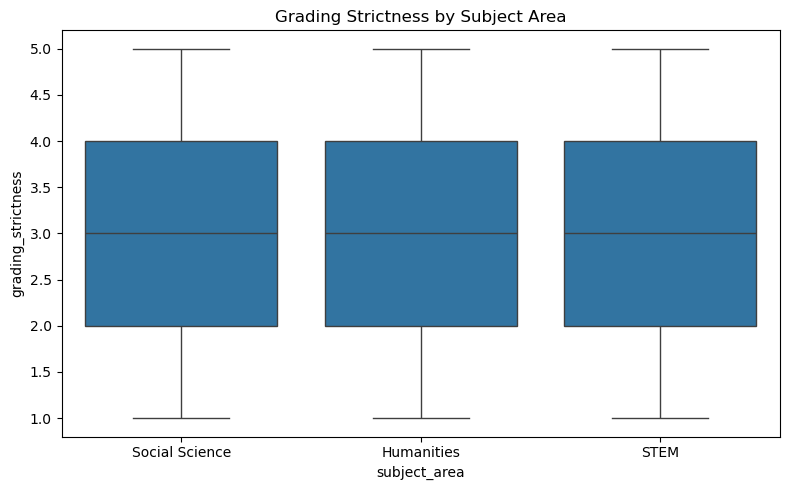

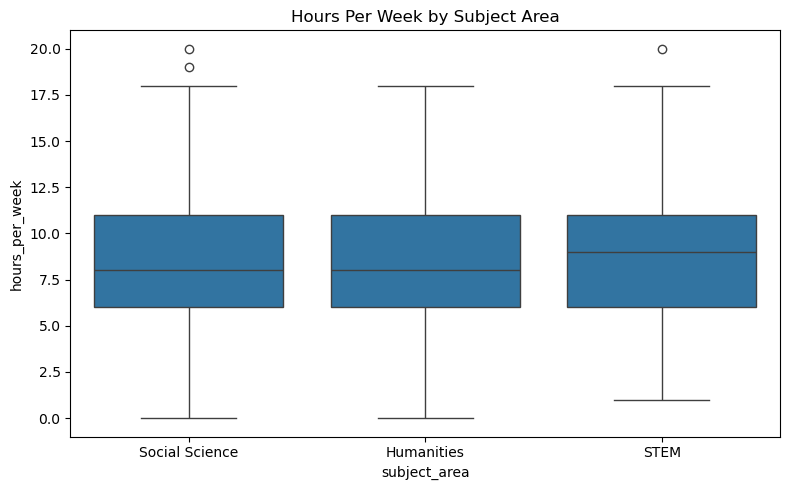

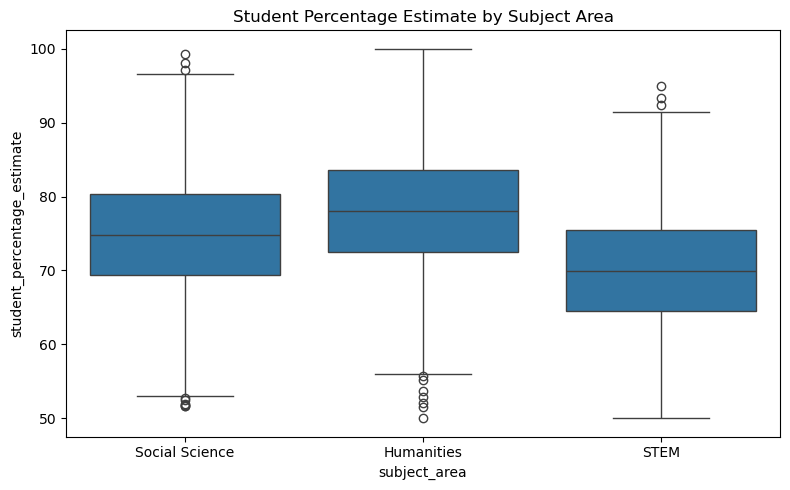

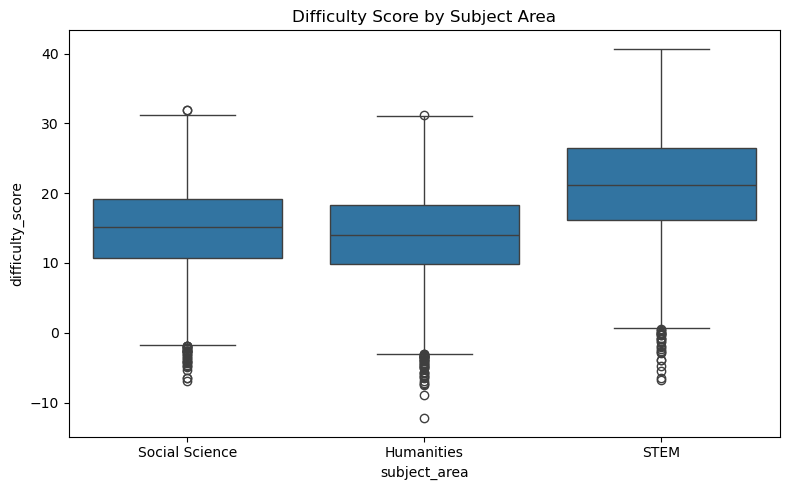

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['grading_strictness', 'hours_per_week', 'student_percentage_estimate', 'difficulty_score']
for feature in features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='subject_area', y=feature, data=df)
    plt.title(f"{feature.replace('_', ' ').title()} by Subject Area")
    plt.tight_layout()
    plt.show()


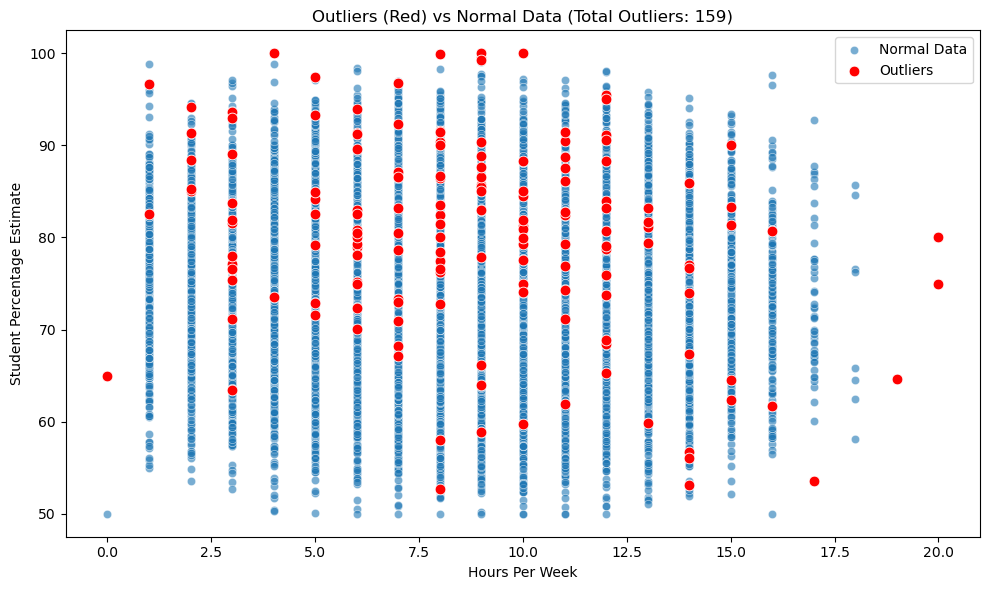

159

In [5]:
import numpy as np
from scipy.stats import zscore

# Identify outliers using Z-score method
z_scores = df.select_dtypes(include='number').apply(zscore)
outlier_mask = (z_scores.abs() > 3).any(axis=1)
outliers = df[outlier_mask]

# Count of outliers
num_outliers = outliers.shape[0]

# Plotting the outliers across selected dimensions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="hours_per_week", y="student_percentage_estimate", label="Normal Data", alpha=0.6)
sns.scatterplot(data=outliers, x="hours_per_week", y="student_percentage_estimate", color="red", label="Outliers", s=60)
plt.title(f"Outliers (Red) vs Normal Data (Total Outliers: {num_outliers})")
plt.xlabel("Hours Per Week")
plt.ylabel("Student Percentage Estimate")
plt.tight_layout()
plt.show()

num_outliers


In [6]:
import pandas as pd
import numpy as np

# Load the clean dataset
corrupted_df = pd.read_csv("course_difficulty_dataset.csv")

# Make the data "dirty" for wrangling tasks

# 1. Introduce missing values randomly (10% of values in selected columns)
cols_with_missing = df.columns.tolist()
cols_with_missing.remove("difficulty_score")
cols_with_missing.remove("difficulty_level")
for col in cols_with_missing:
    corrupted_df.loc[corrupted_df.sample(frac=0.01).index, col] = np.nan

# 2. Introduce extreme outliers artificially
corrupted_df.loc[df.sample(frac=0.001).index, 'hours_per_week'] *= 3  # unrealistic time requirement
corrupted_df.loc[df.sample(frac=0.001).index, 'student_percentage_estimate'] = 150  # impossible percentage

# Save this dirty version to a new CSV
corrupted_df.to_csv("dirty_course_difficulty_dataset.csv", index=False)

corrupted_df.head()
corrupted_df

,course_rating,assignments_per_week,attendance_required,professor_rating,sentiment_score,subject_area,units,hours_per_week,projects,midterms_count,final_exam,grading_strictness,student_percentage_estimate,drop_rate,failure_rate,difficulty_score,difficulty_level
0,1.0,3.0,0.0,1.8,-0.48,Social Science,12.0,13.0,1.0,2.0,0.0,4.1,66.1,0.25,0.32,21.247752,Hard
1,1.0,1.0,1.0,2.0,-0.70,Social Science,9.0,8.0,1.0,0.0,1.0,1.5,93.5,0.08,0.09,8.399222,Easy
2,1.6,3.0,1.0,3.6,-1.00,Humanities,9.0,12.0,1.0,0.0,0.0,3.6,70.7,0.22,0.34,18.504086,Medium
3,1.0,2.0,0.0,2.6,-1.00,STEM,9.0,8.0,0.0,1.0,1.0,2.9,68.9,0.26,0.31,21.957630,Hard
4,1.5,1.0,0.0,1.4,-0.07,STEM,9.0,6.0,1.0,0.0,0.0,2.5,79.4,0.03,0.03,4.552512,Easy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20005,2.0,1.0,0.0,3.0,-0.30,Humanities,3.0,5.0,0.0,0.0,NaN,5.0,60.0,0.10,0.30,13.162826,Medium
20006,5.0,3.0,1.0,5.0,-1.00,STEM,12.0,15.0,1.0,2.0,1.0,3.5,90.0,0.05,0.05,14.160536,Medium
20007,3.0,0.0,1.0,4.0,0.20,STEM,6.0,20.0,1.0,1.0,1.0,3.0,80.0,0.05,0.10,16.843242,Hard
20008,1.0,NaN,1.0,5.0,-0.50,STEM,6.0,8.0,0.0,1.0,1.0,4.0,70.0,0.20,0.20,19.446587,Hard


In [7]:
corrupted_df.isnull().sum()

course_rating                  200
assignments_per_week           200
attendance_required            200
professor_rating               200
sentiment_score                200
subject_area                   200
units                          200
hours_per_week                 200
projects                       200
midterms_count                 200
final_exam                     200
grading_strictness             200
student_percentage_estimate    200
drop_rate                      200
failure_rate                   200
difficulty_score                 0
difficulty_level                 0
dtype: int64

In [8]:
corrupted_df

,course_rating,assignments_per_week,attendance_required,professor_rating,sentiment_score,subject_area,units,hours_per_week,projects,midterms_count,final_exam,grading_strictness,student_percentage_estimate,drop_rate,failure_rate,difficulty_score,difficulty_level
0,1.0,3.0,0.0,1.8,-0.48,Social Science,12.0,13.0,1.0,2.0,0.0,4.1,66.1,0.25,0.32,21.247752,Hard
1,1.0,1.0,1.0,2.0,-0.70,Social Science,9.0,8.0,1.0,0.0,1.0,1.5,93.5,0.08,0.09,8.399222,Easy
2,1.6,3.0,1.0,3.6,-1.00,Humanities,9.0,12.0,1.0,0.0,0.0,3.6,70.7,0.22,0.34,18.504086,Medium
3,1.0,2.0,0.0,2.6,-1.00,STEM,9.0,8.0,0.0,1.0,1.0,2.9,68.9,0.26,0.31,21.957630,Hard
4,1.5,1.0,0.0,1.4,-0.07,STEM,9.0,6.0,1.0,0.0,0.0,2.5,79.4,0.03,0.03,4.552512,Easy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20005,2.0,1.0,0.0,3.0,-0.30,Humanities,3.0,5.0,0.0,0.0,NaN,5.0,60.0,0.10,0.30,13.162826,Medium
20006,5.0,3.0,1.0,5.0,-1.00,STEM,12.0,15.0,1.0,2.0,1.0,3.5,90.0,0.05,0.05,14.160536,Medium
20007,3.0,0.0,1.0,4.0,0.20,STEM,6.0,20.0,1.0,1.0,1.0,3.0,80.0,0.05,0.10,16.843242,Hard
20008,1.0,NaN,1.0,5.0,-0.50,STEM,6.0,8.0,0.0,1.0,1.0,4.0,70.0,0.20,0.20,19.446587,Hard
